In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as itr
import time
from boundaries import WallBoundary, PressureBoundary

# Initializing a rank three tensor filled with nodes
latticeSize = 9
xResolution = 30
yResolution = 30
relaxationTime = 0.5
# Weights
unitVect = np.array([
	[0, 0],	[1, 0], [0, 1],
	[-1, 0], [0, -1], [1, 1],
	[-1, 1], [-1, -1], [1, -1]
])
unitX = np.array([
	0, 1, 0, -1, 0, 1, -1, -1, 1
])
unitY = np.array([
	0, 0, 1, 0, -1, 1, 1, -1, -1
])
weight = np.array([
    4/9, 1/9, 1/9,
    1/9, 1/9, 1/36,
    1/36, 1/36, 1/36
])
cs = np.sqrt(3)

# Initializing the fluid matrix
fluid = np.ones((xResolution, yResolution, latticeSize)) + 0.1 * np.random.randn(xResolution, yResolution, latticeSize)

pressureBoundaries = [PressureBoundary(int(xResolution/2), int(yResolution-1), 1, 1, 2)]

# Assigning a right velocity
fluid[:, :, 1] = 2.3

# Set a boundary
boundary = WallBoundary(xResolution, yResolution, False)
boundary.cylindricalWall([xResolution/2, yResolution/2], 5)

for y, biglist in enumerate(boundary.boundary):
        for x, isAWall in enumerate(biglist):
            if (isAWall):
                for latticeIndex in range(latticeSize):
                     fluid[x, y, latticeIndex] = 0
iteratedFluid = fluid

/tmp/ipykernel_57629/2840740387.py:3: RuntimeWarning: invalid value encountered in divide
  momentum = np.sum(mesoMomentum, axis = 2) / density.reshape(xResolution, yResolution, 1)


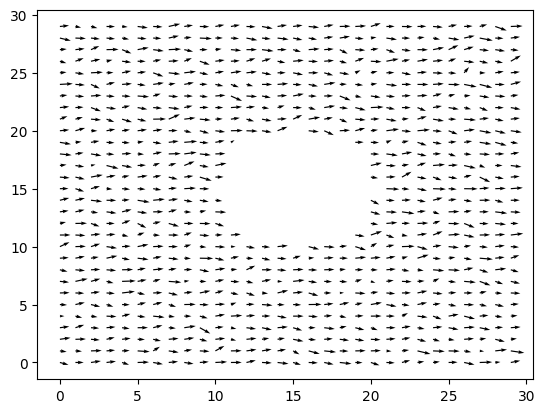

In [2]:
density = np.sum(fluid, axis = 2)
mesoMomentum = fluid.reshape(xResolution, yResolution, latticeSize, 1) * unitVect
momentum = np.sum(mesoMomentum, axis = 2) / density.reshape(xResolution, yResolution, 1)

X = np.arange(xResolution)
Y = np.arange(yResolution)

#print(momentumOut)
plt.quiver(X, Y, momentum[:,:,0], momentum[:,:,1])

In [3]:

# # One iteration only
# iteratedFluid = np.ones((xResolution, yResolution, latticeSize))

# # Internal collision step
# density = np.sum(fluid, axis = 2)
# mesoMomentum = fluid.reshape(xResolution, yResolution, latticeSize, 1) * unitVect
# momentum = np.sum(mesoMomentum, axis = 2) / density.reshape(xResolution, yResolution, 1)
# momentumMagnitude = np.linalg.norm(momentum, axis = 2) ** 2 / (2 * cs**4) # Represents u . u

# # I kinda give up on broadcasting rn. Help me :skull:
# for xIndex, yIndex in itr.product(range(xResolution), range(yResolution)):
#     latticeDensity = density[xIndex, yIndex]
#     cellMomentumMagnitude = momentumMagnitude[xIndex, yIndex]
#     for latticeIndex in range(latticeSize):
#         momentumDot = np.dot(unitVect[latticeIndex], momentum[xIndex, yIndex])
#         fluidEquilibrium = latticeDensity * weight[latticeIndex] * (
# 			1 + momentumDot / (cs ** 2) + momentumDot ** 2 / (cs ** 4) - cellMomentumMagnitude
# 		)
#         iteratedFluid[xIndex, yIndex, latticeIndex] = fluid[xIndex, yIndex, latticeIndex] * (1 - 1/relaxationTime) + 1/relaxationTime * fluidEquilibrium

In [4]:
def dontdoanything():
    x = 1

In [5]:
# for latticeIndex, shiftX, shiftY in zip(range(latticeSize), unitX, unitY):
#     iteratedFluid[:, :, latticeIndex] = np.roll(iteratedFluid[:, :, latticeIndex], shift = shiftX, axis = 1)
#     iteratedFluid[:, :, latticeIndex] = np.roll(iteratedFluid[:, :, latticeIndex], shift = shiftY, axis = 0)

# fluidBoundary = boundary.boundary

# for x, biglist in enumerate(fluidBoundary):
#     for y, isAWall in enumerate(biglist):
#         if (isAWall):
#             for latticeIndex in range(latticeSize):
#                 #for each vector in the lattice, send it back
#                 if (iteratedFluid[x, y, latticeIndex] != 0):
#                     if latticeIndex in [3, 4, 7, 8]:
#                         reflectIndex = latticeIndex - 2
#                     else: 
#                         reflectIndex = latticeIndex + 2
#                     try: 
#                         iteratedFluid[x -  unitX[latticeIndex], y - unitY[latticeIndex], reflectIndex] += iteratedFluid[x, y, latticeIndex]
#                     except:
#                         dontdoanything()
                        
#                     iteratedFluid[x, y, latticeIndex] = 0
                    

# iteratedFluid

In [6]:
def step(fluid):
    # One iteration only
    iteratedFluid = fluid
    # Internal collision step
    density = np.sum(fluid, axis = 2)
    mesoMomentum = fluid.reshape(xResolution, yResolution, latticeSize, 1) * unitVect
    momentum = np.sum(mesoMomentum, axis = 2) / density.reshape(xResolution, yResolution, 1)
    np.nan_to_num(momentum, copy = False)
    #print(list(momentum))
    momentumMagnitude = np.linalg.norm(momentum, axis = 2) ** 2 / (2 * cs**4) # Represents u . u
    np.nan_to_num(momentumMagnitude, copy = False)

    # I kinda give up on broadcasting rn. Help me :skull:
    for xIndex, yIndex in itr.product(range(xResolution), range(yResolution)):
        latticeDensity = density[xIndex, yIndex]
        cellMomentumMagnitude = momentumMagnitude[xIndex, yIndex]
        for latticeIndex in range(latticeSize):
            momentumDot = np.dot(unitVect[latticeIndex], momentum[xIndex, yIndex])
            fluidEquilibrium = latticeDensity * weight[latticeIndex] * (
                1 + momentumDot / (cs ** 2) + momentumDot ** 2 / (cs ** 4) - cellMomentumMagnitude
            )
            iteratedFluid[xIndex, yIndex, latticeIndex] = fluid[xIndex, yIndex, latticeIndex] * (1 - 1/relaxationTime) + 1/relaxationTime * fluidEquilibrium

    for latticeIndex, shiftX, shiftY in zip(range(latticeSize), unitX, unitY):
        iteratedFluid[:, :, latticeIndex] = np.roll(iteratedFluid[:, :, latticeIndex], shift = shiftX, axis = 1)
        iteratedFluid[:, :, latticeIndex] = np.roll(iteratedFluid[:, :, latticeIndex], shift = shiftY, axis = 0)

    np.nan_to_num(iteratedFluid, copy = False)

    fluidBoundary = boundary.boundary

    for y, biglist in enumerate(fluidBoundary):
        for x, isAWall in enumerate(biglist):
            if (isAWall):
                for latticeIndex in range(latticeSize):
                    #for each vector in the lattice, send it back
                    if (iteratedFluid[x, y, latticeIndex] != 0):
                        if latticeIndex in [3, 4, 7, 8]:
                            reflectIndex = latticeIndex - 2
                        else: 
                            reflectIndex = latticeIndex + 2
                        iteratedFluid[x -  unitX[latticeIndex], y - unitY[latticeIndex], reflectIndex] += iteratedFluid[x, y, latticeIndex]
                            
                        iteratedFluid[x, y, latticeIndex] = 0
                    
                    momentum[x,y,0] = 0
                    momentum[x,y,1] = 0

    for pressureBoundary in pressureBoundaries:

        for latticeIndex in range(latticeSize):
                iteratedFluid[pressureBoundary.x, pressureBoundary.y, latticeIndex] = 0
        densityAtIndex = density[pressureBoundary.x, pressureBoundary.y]
        iteratedFluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.setindices[0]] = iteratedFluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.getindices[0]] + (2/3)*(pressureBoundary.mainvelocity)
        iteratedFluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.setindices[1]] = iteratedFluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.getindices[1]] - (0.5 * (iteratedFluid[pressureBoundary.x , pressureBoundary.y, (4 if pressureBoundary.direction - 1 == 0 else pressureBoundary.direction - 1)] - iteratedFluid[pressureBoundary.x , pressureBoundary.y, (1 if pressureBoundary.direction + 1 == 5 else pressureBoundary.direction + 1)])) + (0.5 * densityAtIndex * pressureBoundary.minorvelocity) + (1/6 * densityAtIndex * pressureBoundary.mainvelocity)
        iteratedFluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.setindices[2]] = iteratedFluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.getindices[2]] + (0.5 * (iteratedFluid[pressureBoundary.x , pressureBoundary.y, (4 if pressureBoundary.direction - 1 == 0 else pressureBoundary.direction - 1)] - iteratedFluid[pressureBoundary.x , pressureBoundary.y, (1 if pressureBoundary.direction + 1 == 5 else pressureBoundary.direction + 1)])) - (0.5 * densityAtIndex * pressureBoundary.minorvelocity) + (1/6 * densityAtIndex * pressureBoundary.mainvelocity)

    return iteratedFluid, momentum

/tmp/ipykernel_57629/1264214454.py:7: RuntimeWarning: invalid value encountered in divide
  momentum = np.sum(mesoMomentum, axis = 2) / density.reshape(xResolution, yResolution, 1)


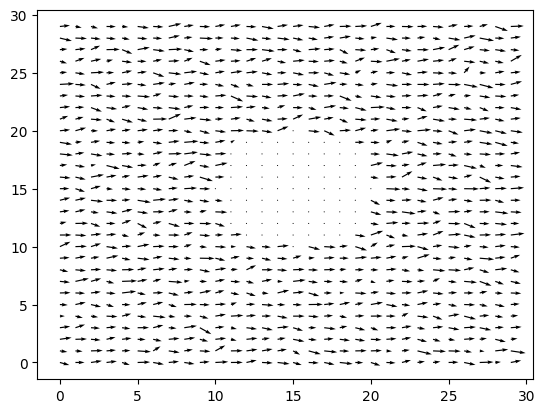

In [7]:
iteratedFluid, momentumOut = step(iteratedFluid)
X = np.arange(xResolution)
Y = np.arange(yResolution)
#print(list(momentumOut))
plt.quiver(X, Y, momentumOut[:,:,0], momentumOut[:,:,1])